In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

#url of the arcane fandom page
url="https://arcane.fandom.com/wiki/Category:Characters"

#send a GET request
response=requests.get(url)
if response.status_code==200:
    soup=BeautifulSoup(response.text,"html.parser")

#extract character names and links
    character_data=[]
    characters=soup.find_all("a",class_="category-page__member-link")
    for char in characters:
        name=char.text.strip()
        link=f"https://arcane.fandom.com{char['href']}"

        character_data.append({"Name":name,"Link":link})

#save to a dataframe
    df=pd.DataFrame(character_data)
    df.to_csv("arcane_characters.csv", index=False)
    print("Character data saved to 'arcane_characters.csv'")

else:
    print(f"Failed to retrieve data from the URL. Status code:{response.status_code}")

    

Character data saved to 'arcane_characters.csv'


In [2]:
print(df)


                                      Name  \
0   Category:Alternate Universe characters   
1                                    Amara   
2                          Ambessa Medarda   
3                                  Babette   
4                                    Benzo   
..                                     ...   
87                                      Vi   
88                   Vi/Alternate Universe   
89                                  Viktor   
90               Viktor/Alternate Universe   
91                            Ximena Talis   

                                                 Link  
0   https://arcane.fandom.com/wiki/Category:Altern...  
1                https://arcane.fandom.com/wiki/Amara  
2      https://arcane.fandom.com/wiki/Ambessa_Medarda  
3              https://arcane.fandom.com/wiki/Babette  
4                https://arcane.fandom.com/wiki/Benzo  
..                                                ...  
87                  https://arcane.fandom.com/wiki/Vi  

In [3]:
arcane=pd.read_csv("arcane_characters.csv")
arcane

,Name,Link
0,Category:Alternate Universe characters,https://arcane.fandom.com/wiki/Category:Altern...
1,Amara,https://arcane.fandom.com/wiki/Amara
2,Ambessa Medarda,https://arcane.fandom.com/wiki/Ambessa_Medarda
3,Babette,https://arcane.fandom.com/wiki/Babette
4,Benzo,https://arcane.fandom.com/wiki/Benzo
...,...,...
87,Vi,https://arcane.fandom.com/wiki/Vi
88,Vi/Alternate Universe,https://arcane.fandom.com/wiki/Vi/Alternate_Un...
89,Viktor,https://arcane.fandom.com/wiki/Viktor
90,Viktor/Alternate Universe,https://arcane.fandom.com/wiki/Viktor/Alternat...


In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

# Load the existing DataFrame
df = pd.read_csv("arcane_characters.csv")

# Function to scrape the biography text from a character's page
def scrape_biography(url):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, "html.parser")
            # Locate the biography section (adjust the class/id based on the page structure)
            bio_section = soup.find("div", class_="mw-parser-output")
            if bio_section:
                return bio_section.get_text(separator=" ").strip()
    except Exception as e:
        print(f"Error scraping {url}: {e}")
    return ""

# Add a biography column to the DataFrame
df['Biography'] = df['Link'].apply(lambda url: scrape_biography(url))

# Save the updated DataFrame
df.to_csv("arcane_characters_with_biographies.csv", index=False)
print("Biographies collected and saved!")


Error scraping https://arcane.fandom.com/wiki/Vander/Alternate_Universe: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
Biographies collected and saved!


In [5]:
biographies=pd.read_csv("arcane_characters_with_biographies.csv")
biographies

,Name,Link,Biography
0,Category:Alternate Universe characters,https://arcane.fandom.com/wiki/Category:Altern...,Characters who are native to different universes.
1,Amara,https://arcane.fandom.com/wiki/Amara,This page contains spoilers for Season 2 of ...
2,Ambessa Medarda,https://arcane.fandom.com/wiki/Ambessa_Medarda,This page contains spoilers for Season 2 of ...
3,Babette,https://arcane.fandom.com/wiki/Babette,This page is a Stub \n \n \n \n This article i...
4,Benzo,https://arcane.fandom.com/wiki/Benzo,This page is a Stub \n \n \n \n This article i...
...,...,...,...
87,Vi,https://arcane.fandom.com/wiki/Vi,This page contains spoilers for Season 2 of ...
88,Vi/Alternate Universe,https://arcane.fandom.com/wiki/Vi/Alternate_Un...,This page contains spoilers for Season 2 of ...
89,Viktor,https://arcane.fandom.com/wiki/Viktor,This page contains spoilers for Season 2 of ...
90,Viktor/Alternate Universe,https://arcane.fandom.com/wiki/Viktor/Alternat...,This page contains spoilers for Season 2 of ...


In [6]:
import re

# Function to count mentions of other characters
def count_mentions(biography, characters):
    mentions = {}
    for char in characters:
        # Use a regular expression to match the character's name in the text
        pattern = r'\b' + re.escape(char) + r'\b'
        mentions[char] = len(re.findall(pattern, biography, flags=re.IGNORECASE))
    return mentions

# Create an empty dictionary to store relationships
relationships = []

# Iterate through each character's biography
character_names = df['Name'].tolist()
for index, row in df.iterrows():
    mentions = count_mentions(row['Biography'], character_names)
    for mentioned_char, count in mentions.items():
        if count > 0 and row['Name'] != mentioned_char:  # Exclude self-references
            relationships.append({
                "source": row['Name'],
                "target": mentioned_char,
                "weight": count
            })

# Convert to a DataFrame
relationships_df = pd.DataFrame(relationships)
relationships_df.to_csv("arcane_relationships.csv", index=False)
print("Character relationships saved!")


Character relationships saved!


In [7]:
character_relationships=pd.read_csv("arcane_relationships.csv")
character_relationships

,source,target,weight
0,Amara,Ambessa Medarda,3
1,Amara,Babette,1
2,Amara,Benzo,1
3,Amara,Caitlyn Kiramman,1
4,Amara,Cassandra Kiramman,1
...,...,...,...
4075,Ximena Talis,Torman Hoskel,1
4076,Ximena Talis,Vander,1
4077,Ximena Talis,Vern,1
4078,Ximena Talis,Vi,1


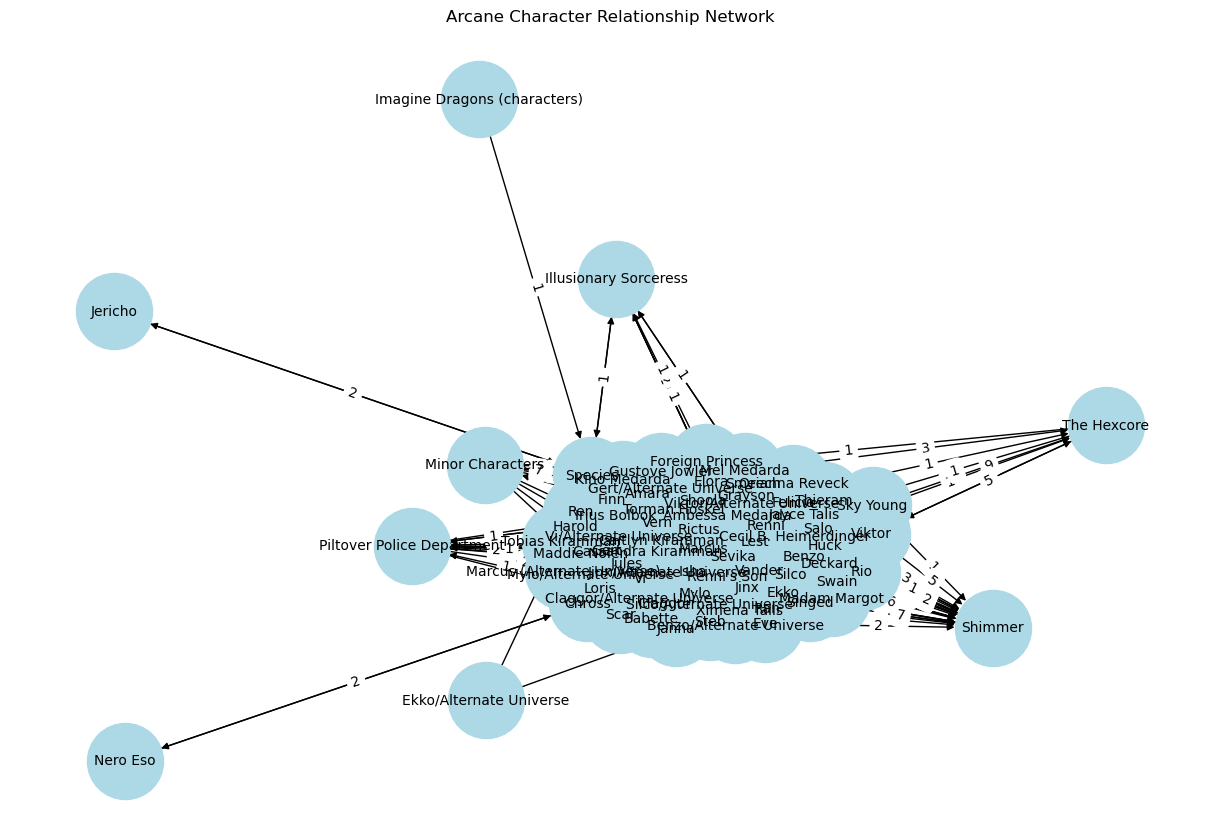

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph from relationships
G = nx.DiGraph()  # Directed graph since mentions are directional
for _, row in relationships_df.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['weight'])

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5)  # Adjust spacing
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10)

# Add edge labels for weights
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Arcane Character Relationship Network")
plt.show()
